In [ ]:
# 1. 데이터 수집 및 Visualization

In [ ]:
#데이터 준비_Giana Dataset

In [1]:
!mkdir -p ~/aiffel/medical
!ln -s ~/data/* ~/aiffel/medical

ln: failed to create symbolic link '/aiffel/aiffel/medical/ed_ckpt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train_labels': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/unet_ckpt': File exists


In [ ]:
# Split dataset into train data and test data(다운로드한 데이터셋을 학습용과 테스트용으로 분리)

In [34]:
import os  # os 모듈 임포트

DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

# 이후 코드를 추가하세요


In [35]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [36]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [7]:
from sklearn.model_selection import train_test_split  # train_test_split 임포트

# 이후에 데이터를 train/test로 분리하는 코드
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)


In [37]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [9]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 192
Number of test examples: 48


In [ ]:
# Visualization (데이터 셋에서 이미지 샘플을 5개 정도 살펴보기)

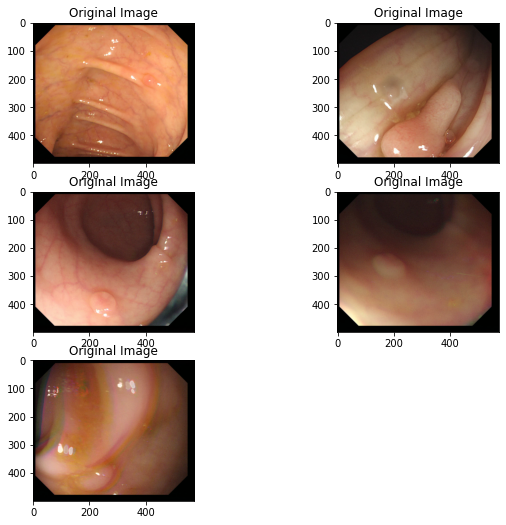

In [14]:
from PIL import Image  # Pillow 라이브러리의 Image 모듈 임포트

import numpy as np  # numpy 라이브러리 임포트
import matplotlib.pyplot as plt  # matplotlib.pyplot 모듈을 plt로 임포트

display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))

for i, idx in enumerate(r_choices):
    x_pathname = x_train_filenames[idx]
    
    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")


In [ ]:
# 위의 라벨은 클래스 값이 아니라, 입력이미지와 동일한 X-Y 사이즈를 가지고 용종 부위만 표시된 1채널짜리 이미지입니다. 
# 즉, 우리가 오늘 도전할 태스크는 Image classification이 아니라 Semantic Segmentation이 됩니다.

In [ ]:
# 2. Data pipeline and Preprocessing

In [ ]:
# Set up hyper-parameters

In [38]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

In [ ]:
# tf.data를 활용한 입력 파이프라인 설계

In [ ]:
# Processing each pathname
#byte 형태로 데이터를 로드하고, bmp로 디코딩하기.
# 디코딩이 완료된 image를 scale과 size를 조절하기 

In [41]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

In [ ]:
# Data augmentation - Shifting the image

In [42]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

In [ ]:
# Data augmentation - Flipping the image randomly

In [43]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

In [ ]:
# Data augmentation Assembling

In [44]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

In [ ]:
# Set up train and test datasets

In [45]:
import functools
import tensorflow as tf

def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=32,  # 기본값 설정
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:  # 학습을 진행할 시에만 augment를 진행합니다.
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset


In [47]:
import os
import functools
import tensorflow as tf
from sklearn.model_selection import train_test_split

# 디렉토리 경로
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')
img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

# 디렉토리 생성
os.makedirs(img_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)

# 파일 경로 리스트 생성
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

# 데이터를 train/test로 분리
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

# 파일 경로를 처리하는 함수
def _process_pathnames(fname, label):
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_jpeg(img_str, channels=3)
    return img, label

# 데이터 증강을 수행하는 함수
def _augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    return img, label

# 데이터셋 생성 함수
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=32,  # 기본값 설정
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:  # 학습을 진행할 시에만 augment를 진행합니다.
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

# 학습 데이터셋 생성
train_dataset = get_baseline_dataset(x_train_filenames, y_train_filenames, is_train=True)
# 테스트 데이터셋 생성
test_dataset = get_baseline_dataset(x_test_filenames, y_test_filenames, is_train=False)


Number of training examples: 240
Number of test examples: 60


In [ ]:
# Plot some train data

In [48]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

InvalidArgumentError: Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext]

In [49]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    print("Shape of images:", images.shape)
    print("Shape of labels:", labels.shape)
    
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()


InvalidArgumentError: Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext]